 # Schools_SynthPops
 This notebook is intended to prepare the school data needed by the `generate_synthetic_population` function of [Synthpops](https://docs.idmod.org/projects/synthpops/en/latest/index.html)
 
 ## Useful Links
 ### Data and data interpreation
 [Open Data](https://dati.istruzione.it/opendata/) <br>
 [Codici Meccanografici](http://www.comuni-italiani.it/001/scuole/)<br>
 [atenei](http://dati.ustat.miur.it/dataset/iscritti/resource/69bd8bbe-73b8-4f00-b0cc-7a6511d87d23http://dati.ustat.miur.it/dataset/iscritti/resource/69bd8bbe-73b8-4f00-b0cc-7a6511d87d23)
 ### History of italian provinces
 [Sud Sardegna](https://it.wikipedia.org/wiki/Provincia_del_Sud_Sardegna)<br>
 [Olbia-Tempio](https://it.wikipedia.org/wiki/Provincia_di_Olbia-Tempio)<br>
 [Ogliastra](https://it.wikipedia.org/wiki/Ogliastra)<br>
 
 ## Ideas
 
 - With respect to ICs, which are school (infancy, elementary ad Lower) complexes whose nature (exact mechanographic code) is impossible to determine:
 > direi allora facciamo una bella media dei volumi di tutti gli asili, elementari e medie e poi dividiamo il volume degli IC per questo valore. Così otteniamo il numero di "scuole efficaci" a cui un IC corrisponde

In [90]:
import pandas as pd
import numpy as np
import ast
import copy
from collections import defaultdict
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import math

In [4]:
# load abbreviation-province name dataset
code_province_df = pd.read_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Administrative\ItalianProvinces.csv")
code_province_df["abbreviation"] = ["NA" if pd.isnull(abbr) else abbr for abbr in code_province_df["abbreviation"]]
code_province_df.head()

,code,name,population,abbreviation
0,1,Torino,2252379,TO
1,2,Vercelli,170296,VC
2,3,Novara,368040,NO
3,4,Cuneo,586568,CN
4,5,Asti,213216,AT


In [5]:
# load school order-mechanographic codes dataset
ORD_MEC_df = pd.read_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\ORDINESCOL2_MEC.tsv", sep = "\t")
ORD_MEC_df["MEC"] = [ast.literal_eval(string) for string in ORD_MEC_df["MEC"]]
ORD_MEC_df

,ORDINESCOL2,MEC
0,PRI,[EE]
1,PRE,[AA]
2,LOW,[MM]
3,UPP,"[PQ, PM, RC, RH, RI, RS, RH, RA , TD, SD, TA, ..."


In [6]:
# utility function
def dct_to_kv_pairs(dct):
    return [(list(dct.keys())[i], list(dct.values())[i]) for i in range(len(dct))]

In [7]:
# convert ORD_MEC_df to a more comfortable dictionary form
ORD_MEC_dct = {row[0]:row[1] for i,row in ORD_MEC_df.iterrows()}
ORD_MEC_lst = dct_to_kv_pairs(ORD_MEC_dct)

{'PRI': ['EE'], 'PRE': ['AA'], 'LOW': ['MM'], 'UPP': ['PQ', 'PM', 'RC', 'RH', 'RI', 'RS', 'RH', 'RA ', 'TD', 'SD', 'TA', 'TB', 'TF', 'TL', 'TN ', 'SL', 'PC', 'PS', 'PL', 'TE', 'PM']}
[('PRI', ['EE']), ('PRE', ['AA']), ('LOW', ['MM']), ('UPP', ['PQ', 'PM', 'RC', 'RH', 'RI', 'RS', 'RH', 'RA ', 'TD', 'SD', 'TA', 'TB', 'TF', 'TL', 'TN ', 'SL', 'PC', 'PS', 'PL', 'TE', 'PM'])]


In [8]:
# load (non university) schools infrastructural data and correct incomaptibilities
scuole_df = pd.read_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\EDICONSISTENZASTA20181920180901.csv")
scuole_df = scuole_df[scuole_df["VOLUME"] != "-"]
scuole_df["VOLUME"] = [float(volume) for volume in scuole_df["VOLUME"].tolist()] # add column "CAPIENZA_SCUOLA"
scuole_df["school_type"] = [string[2:4] for string in scuole_df["CODICESCUOLA"]] 
scuole_df.drop(["CODICEEDIFICIO","SPERFICIEAREATOTALE","SPERFICIEAREALIBERA"], axis = 1, inplace = True) #
print(scuole_df.head())
ORDINESCOL2 = []
for Type in scuole_df["school_type"].tolist():
    found = False
    if Type == "IC":
        ORDINESCOL2.append("IC")
    else:
        for tup in ORD_MEC_lst:
            if Type in tup[1]:
                ORDINESCOL2.append(tup[0])
                found = True
                break
        if not found:
            ORDINESCOL2.append("UPP")
        
scuole_df["ORDINESCOL2"] = ORDINESCOL2

scuole_df["abbreviation"]  = [string[:2] for string in scuole_df["CODICESCUOLA"]]
scuole_df["abbreviation"] = ["FC" if province == "FO" else province for province in scuole_df["abbreviation"] ]
scuole_df["abbreviation"] = ["PU" if province == "PS" else province for province in scuole_df["abbreviation"] ]
scuole_df.drop(["school_type","ANNOSCOLASTICO"], axis = 1, inplace = True)
cols = scuole_df.columns.tolist()
scuole_df = scuole_df[[cols[-1]]+[cols[0]]+[cols[-2]]+[cols[-3]]]

# groupby schools by province and order
scuole_gb_provincia_ordine_df = scuole_df.groupby(["abbreviation","ORDINESCOL2"], as_index = False).agg({"VOLUME":"sum"})
scuole_df.head()

   ANNOSCOLASTICO CODICESCUOLA   VOLUME school_type
0          201819   FGEE82302X   7000.0          EE
1          201819   COTD00101T  35000.0          TD
2          201819   CTAA08305Q    435.0          AA
3          201819   MITF11000E   9068.0          TF
5          201819   CSIS06100T  18600.0          IS
Index(['abbreviation', 'CODICESCUOLA', 'ORDINESCOL2', 'VOLUME'], dtype='object')


In [9]:
# create utility dictionary
ICs_df = copy.deepcopy(scuole_df[scuole_df["ORDINESCOL2"] == "IC"])
ICs_df["count"] = [1 for i in range(len(ICs_df))]
ICs_df = ICs_df.groupby(["abbreviation"],as_index = False).agg({"count":"sum"})
ICs_per_province_dct = {row[0]:row[1] for i,row in ICs_df.iterrows() }
for abbr in code_province_df["abbreviation"]:
    try:
        ICs_per_province_dct[abbr]
    except KeyError as e:
        ICs_per_province_dct[abbr] = 1

,abbreviation,count
0,AG,46
1,AN,45
2,AO,15
3,AP,30
4,AQ,25
...,...,...
90,VE,66
91,VI,80
92,VR,66
93,VT,30


In [13]:
# utility functions
def encapsulate(value):
    return [value]

def my_reduce(lst):
    return [lst[0]+lst[1],lst[2]+lst[3],(lst[4]+lst[5])/2.,lst[6]+lst[7]]
# this function takes as inputs the three lists (grouped in a series) containing the c_i_ic_s of the LOW, PRI and PRE school orders of a province and produces the list of the estimated s_c_i_ic of the ICs of that province (sums the first three elements and evaluates the fourth dividing the third by the second)
def sum_average(series):
    #print(series)
    zipped = list(zip(series.tolist()[0],series.tolist()[1],series.tolist()[2]))
    return [(sum(zipped[0])/sum(zipped[3]))*ICs_per_province_dct[zipped[4][0]],(sum(zipped[1])/sum(zipped[3]))*ICs_per_province_dct[zipped[4][0]],((sum(zipped[1])/sum(zipped[3]))*ICs_per_province_dct[zipped[4][0]])/((sum(zipped[0])/sum(zipped[3]))*ICs_per_province_dct[zipped[4][0]]),sum(zipped[3])]

In [14]:
%%time
# load enrolemnts per chool order and province dataset
students_by_province_df = pd.read_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\DCIS_SCUOLE_iscritti_per_scuola_2.csv")
# drop useless columns
students_by_province_df = students_by_province_df.drop(["Flag Codes","Flags", "Seleziona anno (anno t= anno sc. t-1 / t)","TIPO_DATO_ISTR","Ordine scolastico","NATGIUR1","TIME","Gestione della scuola","ITTER107"], axis =1)


# correct incompatibiliries
students_by_province_df["Territorio"] = ["Forli'-Cesena" if province == 'Forlì-Cesena' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Massa Carrara' if province == 'Massa-Carrara' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Sud Sardegna' if province in ['Carbonia-Iglesias','Medio Campidano'] else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Sassari' if province == 'Olbia-Tempio' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Nuoro' if province == 'Ogliastra' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Trento' if province == 'Provincia Autonoma Trento' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Bolzano' if province == 'Provincia Autonoma Bolzano / Bozen' else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["Territorio"] = ['Aosta' if province == "Valle d'Aosta / Vallée d'Aoste" else province  for province in students_by_province_df["Territorio"].to_list() ]
students_by_province_df["abbreviation"] = [couple[1] for Territorio in students_by_province_df["Territorio"].to_list() for couple in zip(code_province_df["name"].to_list(),code_province_df["abbreviation"].to_list() ) if Territorio == couple[0]]
students_by_province_df["Value"] = [encapsulate(value) for value in students_by_province_df["Value"] ] 
students_by_province_df.sort_values(by = ["abbreviation","ORDINESCOL2","Tipo dato"], inplace = True)

# groupby province and order
students_by_province_gb_df = students_by_province_df.groupby(["Territorio","abbreviation","ORDINESCOL2"], as_index = False).agg({"Value":"sum"})
students_by_province_gb_df.columns = ["Territorio","abbreviation","ORDINESCOL2","c_i_ic_s"]
sud_sardegna_post = students_by_province_gb_df[students_by_province_gb_df["Territorio"] == "Sud Sardegna"]
students_by_province_gb_df["c_i_ic_s"] = [c_i_ic_s if len(c_i_ic_s) == 4 else my_reduce(c_i_ic_s) for c_i_ic_s in students_by_province_gb_df["c_i_ic_s"]]
sud_sardegna_post2 = students_by_province_gb_df[students_by_province_gb_df["Territorio"] == "Sud Sardegna"]

# approximate for ICs
students_by_province_gb_noUPP_df = copy.deepcopy(students_by_province_gb_df[students_by_province_gb_df["ORDINESCOL2"] != "UPP"])
students_by_province_gb_noUPP_df["c_i_ic_s"] = [row[3] + [row[1]] for i,row in students_by_province_gb_noUPP_df.iterrows()]
students_by_province_gb_noUPP_gb_df = students_by_province_gb_noUPP_df.groupby(["Territorio","abbreviation"],as_index = False).agg({"c_i_ic_s":sum_average})
students_by_province_gb_noUPP_gb_df["ORDINESCOL2"] = ["IC" for i in range(len(students_by_province_gb_noUPP_gb_df))]

#concat ICs dataset with above non-ICs dataset
students_by_province_gb_df = pd.concat([students_by_province_gb_df, students_by_province_gb_noUPP_gb_df], ignore_index=True)


# merge with grouped schools dataset
scuole_gb_provincia_ordine_merged_df = scuole_gb_provincia_ordine_df.merge(right =students_by_province_gb_df , on = ["abbreviation","ORDINESCOL2"],validate = "one_to_one")
scuole_gb_provincia_ordine_merged_df["#classi/volume"] = [row[4][0]/row[2] for i,row in scuole_gb_provincia_ordine_merged_df.iterrows() ]

# evaluate approximation factors
scuole_df["#classi/volume"] = [scuole_gb_provincia_ordine_merged_df.loc[(scuole_gb_provincia_ordine_merged_df["abbreviation"] == row[0] ) & (scuole_gb_provincia_ordine_merged_df["ORDINESCOL2"] == row[2] ),"#classi/volume" ].tolist()[0] for i,row in scuole_df.iterrows()]
scuole_df["iscritti_per_classe"] = [scuole_gb_provincia_ordine_merged_df.loc[(scuole_gb_provincia_ordine_merged_df["abbreviation"] == row[0] ) & (scuole_gb_provincia_ordine_merged_df["ORDINESCOL2"] == row[2] ),"c_i_ic_s" ].tolist()[0][2] for i,row in scuole_df.iterrows()]

# evaluate enrollements and clean dataset
scuole_df["enrollments"] = scuole_df["#classi/volume"]*scuole_df["VOLUME"]*scuole_df["iscritti_per_classe"]
scuole_df.drop(["VOLUME","#classi/volume","iscritti_per_classe"], inplace = True, axis = 1)

scuole_df.head()

Index(['abbreviation', 'CODICESCUOLA', 'ORDINESCOL2', 'enrollments'], dtype='object')
Wall time: 41 s


In order to estimate ICs' capacity, we need to average over school orders (**ORDINESCOL2**) of **LOW**, **PRE** and **PRI** departments in every province.  

In [15]:
sum(scuole_df["enrollments"].to_list()) #merda!!

8224763.114917536

$numero_classi_scuola_provincia_ordine_volume = (numero_classi_provicia_ordine/somma_volumi_scuole_provincia_ordine)*volume$ <br>
$studenti_scuola_provincia_ordine_volume = numero_classi_scuola_provincia_ordine_volume *iscritti_per_classe_provincia_ordine$<br>

In [20]:
%%time
#l oad university data
universities_df = pd.read_csv(r"E:\IlMIoDrive\magistrale\2anno\primo_periodo\epi\Data\CSV\2020\Infrastructural\università_open_data.csv")

# add temporary provinces, draw from univerities names
universities_df["province"] = [name.split()[0] for name in universities_df["AteneoNOME"] ]
universities_df["province"] = ["Potenza" if province == "Basilicata" else province for province in universities_df["province"] ]
universities_df["province"] = ["Cuneo" if province == "Bra" else province for province in universities_df["province"] ]
universities_df["province"] = ["Cosenza" if province == "Calabria" else province for province in universities_df["province"] ]
universities_df["province"] = ["Macerata" if province == "Camerino" else province for province in universities_df["province"] ]
universities_df["province"] = ["Bari" if province == "Casamassima" else province for province in universities_df["province"] ]
universities_df["province"] = ["Frosinone" if province == "Cassino" else province for province in universities_df["province"] ]
universities_df["province"] = ["Varese" if province == "Castellanza" else province for province in universities_df["province"] ]
universities_df["province"] = ["Verbano-Cusio-Ossola" if province == "Insubria" else province for province in universities_df["province"] ]
universities_df["province"] = ["Ancona" if province == "Marche" else province for province in universities_df["province"] ]
universities_df["province"] = ["Campobasso" if province == "Molise" else province for province in universities_df["province"] ]
universities_df["province"] = ["Como" if province == "Novedrate" else province for province in universities_df["province"] ]
universities_df["province"] = ["Vercelli" if province == "Piemonte" else province for province in universities_df["province"] ]
universities_df["province"] = ["Reggio di Calabria" if province == "Reggio" else province for province in universities_df["province"] ]
universities_df["province"] = ["Milano" if province == "Rozzano" else province for province in universities_df["province"] ]
universities_df["province"] = ["Lecce" if province == "Salento" else province for province in universities_df["province"] ]
universities_df["province"] = ["Benevento" if province == "Sannio" else province for province in universities_df["province"] ]
universities_df["province"] = ["Roma" if province == "Torrevecchia" else province for province in universities_df["province"] ]
universities_df["province"] = ["Viterbo" if province == "Tuscia" else province for province in universities_df["province"] ]
universities_df["province"] = ["Pesaro e Urbino" if province == "Urbino" else province for province in universities_df["province"] ]

# associate province abbreviation based on temporary names
universities_df_abbreviation = [] #
found = False
universities_provinces = set(universities_df["province"])
#provice_abbreviations = set(code_province_df[""])
for j,rowj in universities_df.iterrows():
    found = False
    for i, rowi in code_province_df.iterrows():
        if rowj["province"].lower() == rowi["name"].lower():
            universities_df_abbreviation.append(rowi["abbreviation"])
            found = True
            break
    if not found:
        universities_df_abbreviation.append("-")
        
universities_df["abbreviation"] = universities_df_abbreviation 
print("malformed  = ", len(universities_df[universities_df["abbreviation"] == "-"]))


# prepare university dataset for concat with scuole_df
universities_gb_df = universities_df.groupby(["abbreviation", "AteneoNOME"], as_index = False).agg({"Isc":"sum"})
universities_gb_df["ORDINESCOL2"] = ["UNI" for i in range(len(universities_gb_df))] 
universities_gb_df.columns = ["abbreviation", "CODICESCUOLA", "enrollments", "ORDINESCOL2"]
cols = universities_gb_df.columns
universities_gb_df.columns = [[cols[0]]+ [cols[1]]+ [cols[2]]+[cols[3]]]
# i don't know
universities_gb_df.columns = universities_gb_df.columns.to_flat_index()
universities_gb_df.columns  = pd.Index([col[0] for col in universities_gb_df.columns])
# universi

print(universities_gb_df.head())
# print("\n ---------------------- \n")
# print('len(set(universities_df["ClasseNUMERO"])) = ',len(set(universities_df["ClasseNUMERO"])))
# print('len(set(universities_df["ClasseNOME"])) = ',len(set(universities_df["ClasseNOME"])))

Index(['abbreviation', 'CODICESCUOLA', 'ORDINESCOL2', 'enrollments'], dtype='object')
malformed  =  0
  abbreviation      CODICESCUOLA  enrollments ORDINESCOL2
0           AN            Marche        14980         UNI
1           AO             Aosta         1021         UNI
2           AQ          L'Aquila        15965         UNI
3           BA              Bari        42673         UNI
4           BA  Bari Politecnico         9824         UNI
Wall time: 28.9 s


In [21]:
all_schools_df = pd.concat([universities_gb_df,scuole_df], ignore_index = True)
all_schools_df

,abbreviation,CODICESCUOLA,enrollments,ORDINESCOL2
0,AN,Marche,14980.000000,UNI
1,AO,Aosta,1021.000000,UNI
2,AQ,L'Aquila,15965.000000,UNI
3,BA,Bari,42673.000000,UNI
4,BA,Bari Politecnico,9824.000000,UNI
...,...,...,...,...
56649,VE,VEIC838006,440.928297,IC
56650,BO,BOEE825026,142.613123,PRI
56651,VI,VIEE81202C,7.251542,PRI
56652,TO,TOAA029022,62.779123,PRE


In [22]:
sum(all_schools_df["enrollments"].tolist()) # it is roughly correct. see istat data

9883033.114917684

In [43]:
all_schools_df.sort_values(by = ["enrollments"], inplace = True,ascending = False)

In [54]:
all_schools_df.head(50)

,abbreviation,CODICESCUOLA,enrollments,ORDINESCOL2
59,RM,Roma La Sapienza,102049.000000,UNI
9,BO,Bologna,80428.000000,UNI
41,NA,Napoli Federico II,73741.000000,UNI
75,TO,Torino,73049.000000,UNI
31,MI,Milano,59353.000000,UNI
47,PD,Padova,58720.000000,UNI
23,FI,Firenze,51633.000000,UNI
36,MI,Milano Politecnico,44923.000000,UNI
50,PI,Pisa,44900.000000,UNI
3,BA,Bari,42673.000000,UNI


In [60]:
enr = all_schools_df["enrollments"].tolist()

In [66]:
len(enr)

56654

In [95]:
math.exp(1)

2.718281828459045

In [113]:
bins = np.logspace(0,math.log(max(enr),math.exp(1)),base= math.exp(1), num = 100)

In [114]:
len(bins)

100

In [24]:
total = len()
def get_freq(data, total):
    return sum(data)/total

In [142]:
def get_distrib(df, abbr,num = 50, base = math.exp(1)):
    abbr_df = df[df["abbreviation"] == abbr]
    data = df["enrollments"].tolist()
    bins = np.logspace(0,math.log(max(enr),base),base= base,num = num)
    return binned_statistic(data, data, statistic = "count", bins=bins)

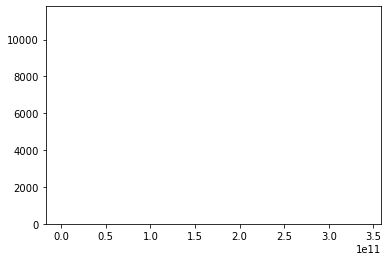

In [99]:
plt.hist(all_schools_df["enrollments"].tolist(), bins = bins)
plt.show()

In [39]:
max(all_schools_df["enrollments"].tolist())

102049.0

In [176]:
distrib = get_distrib(all_schools_df,abbr = "TO", num = 15, base = 10)

In [177]:
distrib

BinnedStatisticResult(statistic=array([4.6000e+01, 3.1500e+02, 1.7050e+03, 5.9960e+03, 1.2314e+04,
       1.6693e+04, 1.4424e+04, 4.4240e+03, 5.2000e+02, 8.9000e+01,
       3.4000e+01, 3.8000e+01, 2.3000e+01, 8.0000e+00]), bin_edges=array([1.00000000e+00, 2.27914551e+00, 5.19450427e+00, 1.18390311e+01,
       2.69828746e+01, 6.14978976e+01, 1.40162657e+02, 3.19451092e+02,
       7.28075522e+02, 1.65939006e+03, 3.78199141e+03, 8.61970875e+03,
       1.96455705e+04, 4.47751139e+04, 1.02049000e+05]), binnumber=array([13, 14, 14, ...,  0,  0,  0], dtype=int64))

In [178]:
counts = distrib[0]
edges = distrib[1]
type(counts)

numpy.ndarray

In [179]:
final_df = pd.DataFrame({"school_size": [[round(edges[i]),round(edges[i+1])] for i in range(len(edges)-1)], "percent":[count/sum(counts) for count in counts]})

In [180]:
final_df

,school_size,percent
0,"[1, 2]",0.000812
1,"[2, 5]",0.005563
2,"[5, 12]",0.030108
3,"[12, 27]",0.105882
4,"[27, 61]",0.217450
5,"[61, 140]",0.294778
6,"[140, 319]",0.254710
7,"[319, 728]",0.078123
8,"[728, 1659]",0.009183
9,"[1659, 3782]",0.001572
